# 1. Introduction

**Project Summary**:

This project focuses on developing a **machine learning model** to predict the presence of dementia in patients based on their medical histories, cognitive assessments, clinician judgment of symptoms and demographic data. 

**RandomForest** and **XGBoost** were used, employing techniques such as **stratified sampling** to address **class imbalance**.

Model evaluation was conducted using metrics such as **accuracy, recall, F1-score, and the ROC curve**, providing a comprehensive view of the model's performance on both balanced and imbalanced datasets. Strategies were explored to enhance predictive capability and model interpretation, including the identification of influential variables.

In summary, the project aims to develop a robust and equitable model for dementia detection, leveraging detailed analysis of patients' medical history, demographics and cognitive assessments.

In [477]:
###### Step 1: Import Libraries

# Data processing
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model and performance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import xgboost as xgb

# Over sampling and under sampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

from tabulate import tabulate
#from sklearn.model_selection import GridSearchCV

In [3]:
pd.set_option('display.max_columns', None)

# 2. Data preparation

## 2.1. Load the data

In [529]:
health = pd.read_csv('OASIS3_UDSa5_health_history.csv')
globaldata = pd.read_csv("OASIS3_UDSb4_cdr.csv")
uds = pd.read_csv("OASIS3_UDSb9_symptoms.csv")
demo =pd.read_csv("OASIS3_demographics.csv")

In [531]:
globaldata.columns

Index(['OASISID', 'OASIS_session_label', 'days_to_visit', 'age at visit',
       'MMSE', 'memory', 'orient', 'judgment', 'commun', 'homehobb',
       'perscare', 'CDRSUM', 'CDRTOT', 'dx1_code', 'dx2_code', 'dx3_code',
       'dx4_code', 'dx5_code', 'dx1', 'dx2', 'dx3', 'dx4', 'dx5'],
      dtype='object')

The 4 datasets have the following variables in common:
    
- OASISID: An identifier for each individual in the dataset.
- OASIS_session_label: Label or identifier for a specific session or visit.
- days_to_visit: The number of days until the next visit.
- age at visit: Age of the individual at the time of the visit.


**Dataset "health": Medical history**

In [5]:
health.head()

,OASISID,OASIS_session_label,days_to_visit,age at visit,CVHATT,CVAFIB,CVANGIO,CVBYPASS,CVPACE,CVCHF,CVOTHR,CBSTROKE,CBTIA,CBOTHR,PD,PDOTHR,SEIZURES,TRAUMBRF,TRAUMEXT,TRAUMCHR,NCOTHR,HYPERTEN,HYPERCHO,DIABETES,B12DEF,THYROID,INCONTU,INCONTF,DEP2YRS,DEPOTHR,ALCOHOL,TOBAC30,TOBAC100,SMOKYRS,PACKSPER,QUITSMOK,ABUSOTHR,PSYCDIS,PARKIF,ALCOCCAS,ALCFREQ,HATTMULT,CVPACDEF,CVANGINA,CVHVALVE,STROKMUL,TIAMULT,TBI,TBIBRIEF,TBIEXTEN,TBIWOLOS,DIABTYPE,ARTHRIT,ARTHTYPE,ARTHUPEX,ARTHLOEX,ARTHSPIN,ARTHUNK,APNEA,RBD,INSOMN,OTHSLEEP,PTSD,BIPOLAR,SCHIZ,ANXIETY,OCD,NPSYDEV,stroke_tia,hbp,seiz,headinj
0,OAS30001,OAS30001_UDSa5_d0000,0,65.19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,88.0,8.0,888.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OAS30001,OAS30001_UDSa5_d0339,339,66.12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,88.0,8.0,888.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OAS30001,OAS30001_UDSa5_d0722,722,67.17,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,88.0,8.0,888.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OAS30001,OAS30001_UDSa5_d1106,1106,68.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,88.0,8.0,888.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OAS30001,OAS30001_UDSa5_d1456,1456,69.18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.0,8.0,888.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
health.shape

(8499, 72)

The first dataset contains detailed information about patients' **medical history**, encompassing a total of 72 variables related to various medical issues. Some of the noteworthy variables include:

- CVHATT: Cardiovascular disease - History of heart attack.
- CVAFIB: Cardiovascular disease - Atrial fibrillation.
- CVANGIO: Cardiovascular disease - Angioplasty.
- CVBYPASS: Cardiovascular disease - Bypass surgery.
- CVPACE: Cardiovascular disease - Pacemaker.
- CVCHF: Cardiovascular disease - Congestive heart failure.
- CVOTHR: Cardiovascular disease - Other heart conditions.


- CBSTROKE: Cerebrovascular disease - Stroke.
- CBTIA: Cerebrovascular disease - Transient ischemic attack.
- CBOTHR: Cerebrovascular disease - Other cerebrovascular conditions.


- TOBAC30: Tobacco use within the past 30 days.
- TOBAC100: Tobacco use within the past 100 days.
- SMOKYRS: Number of smoking years.
- PACKSPER: Packs per year.
- QUITSMOK: Quit smoking.


- APNEA: Sleep apnea.
- RBD: Rapid eye movement behavior disorder.
- INSOMN: Insomnia.
- OTHSLEEP: Other sleep disorders.

**Dataset "globaldata": Cognitive assessment**

In [7]:
globaldata.head()

,OASISID,OASIS_session_label,days_to_visit,age at visit,MMSE,memory,orient,judgment,commun,homehobb,perscare,CDRSUM,CDRTOT,dx1_code,dx2_code,dx3_code,dx4_code,dx5_code,dx1,dx2,dx3,dx4,dx5
0,OAS30001,OAS30001_UDSb4_d0000,0,65.19,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,Cognitively normal,.,.,.,.
1,OAS30001,OAS30001_UDSb4_d0339,339,66.12,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,Cognitively normal,.,.,.,.
2,OAS30001,OAS30001_UDSb4_d0722,722,67.17,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,Cognitively normal,.,.,.,.
3,OAS30001,OAS30001_UDSb4_d1106,1106,68.22,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,Cognitively normal,.,.,.,.
4,OAS30001,OAS30001_UDSb4_d1456,1456,69.18,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,Cognitively normal,.,.,.,.


In [9]:
globaldata.shape

(8626, 23)

The second dataset includes results from **cognitive assessments**. It contains the column CDRSUM(Clinical Dementia Rating), a numeric scale used to quantify the severity of dementia symptoms. We created our target variable "Outcome" from this column, with labels for dementia(1) or non-dementia(0).

In [73]:
#define a function that creates our target variable "Outcome". 1= dementia, 0= non dementia. From 1 is considered mild dementia

def CDR_info(row):
    if row['CDRSUM'] > 1:
        return 1
    else:
        return 0  # If none of the conditions are met, set the value to 0

# Apply the custom function to create a new column 'COMBINED_CV'
globaldata['Outcome'] = globaldata.apply(CDR_info, axis=1)

Other variables in "globaldata":

- The Mini-Mental State Examination (MMSE) measures general cognitive status, with scores ranging from 0 (severe     impairment to 30 (no impairment).
- 'Memory': Evaluation of memory
- 'orient': Spatial and temporal orientation
- 'judgment': Judgment capacity,
- 'commun': Community affairs
- 'homehobb': Home and hobbies
- 'perscare': Personal care
- 'dx2': Illnesses

Note that the feature CDRSUM is actually the sum of the scores of six features including MEMORY, ORIENT, JUDGMENT, COMMUN, HOMEHOBB, PERSCARE

**Dataset "demo": Demographic data**

In [15]:
demo.head()

,OASISID,Subject_accession,AgeatEntry,AgeatDeath,GENDER,EDUC,SES,racecode,race,ETHNIC,AIAN,NHPI,ASIAN,AA,WHITE,daddem,momdem,HAND,APOE
0,OAS30001,NaN,65.1945,NaN,2,12.0,4.0,5,White,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,R,23.0
1,OAS30002,NaN,67.2521,76.9397,1,18.0,2.0,5,White,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,R,34.0
2,OAS30003,NaN,58.8137,NaN,2,18.0,1.0,5,White,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,R,33.0
3,OAS30004,NaN,55.1342,NaN,2,17.0,1.0,5,White,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,L,23.0
4,OAS30005,NaN,48.0630,NaN,2,16.0,3.0,2,ASIAN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,R,33.0


In [16]:
demo.shape

(1378, 19)

From this dataset, we decided to use the variables: 

- GENDER	
- EDUC: Subject’s years of education	
- SES: Socieconomic status
- racecode: What does subject report as his/her race?	
- daddem: Dad demented
- momddem: Mom demented
- HAND: Left- or right-handed
- APOE: APOE genotype, a genetic risk factor for dementia, Alzheimer's disease

**Dataset "uds": Clinician Judgment of Symptoms**

In [17]:
uds.head()

,OASISID,OASIS_session_label,days_to_visit,age at visit,DECSUB,DECIN,DECCLIN,DECCLCOG,DECAGE,COGMEM,COGJUDG,COGORI,COGLANG,COGVIS,COGATTN,COGFLUC,COGFLAGO,COGOTHR,COGFRST,COGFPRED,COGMODE,DECCLBE,BEAPATHY,BEDEP,BEVHALL,BEVWELL,BEVHAGO,BEAHALL,BEDEL,BEDISIN,BEIRRIT,BEAGIT,BEPERCH,BEREM,BEANX,BEOTHR,BEFRST,BEFPRED,BEAGE,BEMODE,DECCLMOT,MOGAIT,MOFALLS,MOTREM,MOSLOW,MOFRST,MOMODE,MOMOPARK,PARKAGE,MOMOALS,ALSAGE,MOAGE,COURSE,FRSTCHG,b9chg,BEREMAGO,LBDEVAL,FTLDEVAL
0,OAS30001,OAS30001_UDSb9_d0000,0,65.19,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OAS30001,OAS30001_UDSb9_d0339,339,66.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
2,OAS30001,OAS30001_UDSb9_d0722,722,67.17,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OAS30001,OAS30001_UDSb9_d1106,1106,68.22,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OAS30001,OAS30001_UDSb9_d1456,1456,69.18,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
uds.shape

(8499, 58)

From this dataset, we decided to use the following variables, as they presented the lowest number of null data:

- DECSUB: Decline reported by subject	
- DECIN: Decline reported by informant
- DECCLIN: Decline reported by clinician	
- DECCLCOG: Impairment in cognition	reported by clinician
- DECAGE: What age did the cognitive decline begin?- Reported by clinician

# 2.2 Check for missing values(NaN)

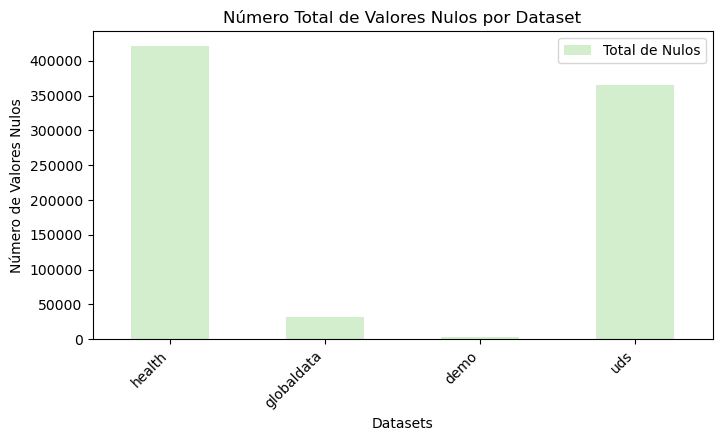

In [56]:
# We check for missing values in all the dataset
total_nulls_df1 = health.isnull().sum().sum()
total_nulls_df2 = globaldata.isnull().sum().sum()
total_nulls_df3 = demo.isnull().sum().sum()
total_nulls_df4 = uds.isnull().sum().sum()

# Create a DataFrame with null values
null_counts = pd.DataFrame({
    'Dataset': ['health', 'globaldata', "demo", "uds"],
    'Total de Nulos': [total_nulls_df1, total_nulls_df2, total_nulls_df3, total_nulls_df4]
})


# Graphic to compare the number of null values in each dataset
colors = sns.color_palette("Greens", len(null_counts))
null_counts.plot(kind='bar', figsize=(8, 4), color=colors)
plt.title('Número Total de Valores Nulos por Dataset')
plt.xlabel('Datasets')
plt.ylabel('Número de Valores Nulos')
plt.xticks(rotation=45, ha='right')
#plt.legend(title='Datasets')
plt.xticks(range(len(null_counts)), null_counts['Dataset'])
plt.show()


The dataset "health" is the one with more missing values. We check for the columns in this dataset with more number of nulls.

In [58]:
health.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8499 entries, 0 to 8498
Data columns (total 72 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   OASISID              8499 non-null   object 
 1   OASIS_session_label  8499 non-null   object 
 2   days_to_visit        8499 non-null   int64  
 3   age at visit         8499 non-null   float64
 4   CVHATT               4380 non-null   float64
 5   CVAFIB               4379 non-null   float64
 6   CVANGIO              4379 non-null   float64
 7   CVBYPASS             4379 non-null   float64
 8   CVPACE               4033 non-null   float64
 9   CVCHF                4379 non-null   float64
 10  CVOTHR               4378 non-null   float64
 11  CBSTROKE             4379 non-null   float64
 12  CBTIA                4379 non-null   float64
 13  CBOTHR               4029 non-null   float64
 14  PD                   4379 non-null   float64
 15  PDOTHR               4380 non-null   f

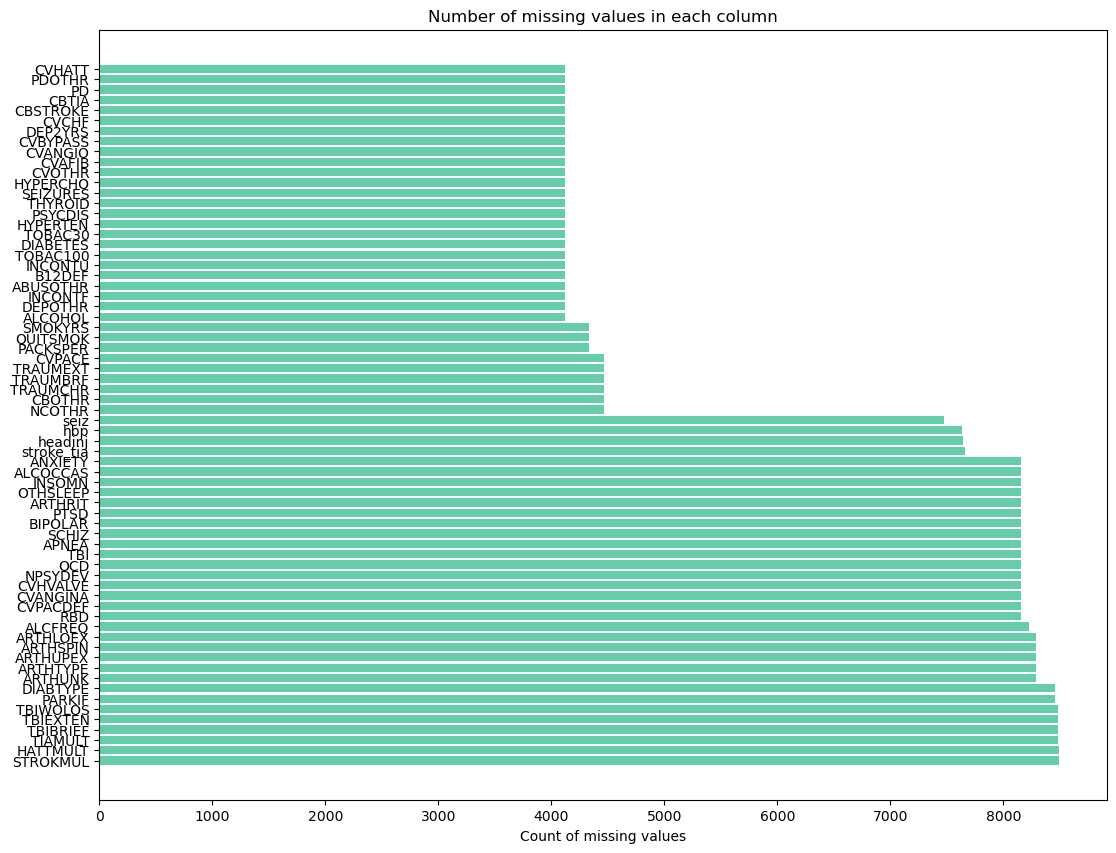

In [59]:
#Plot missing values for each column
ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(13,10))
rects = ax.barh(ind, missing_df.missing_count.values, color= "mediumaquamarine")
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

## 2.2.1. Column removal in the dataset "health"

Some columns such as HATTMULT (History of multiple heart attacks) have many null values with only 11 non-null entries. The same happens with TIAMULT (Multiple transient ischemic attacks) - 14 non-null entries. Also, TBIBRIEF: Brief traumatic brain injury. TBIEXTEN: Extended traumatic brain injury. TBIWOLOS: Traumatic brain injury with loss of consciousness. have only 17 non-null entries. Finally, STROKMUL (Multiple strokes) only has 9 non-null entries. 

We define a function to remove the columns that have a great amount of NaNs

In [74]:
def eliminarcolum(dataset):
    dataset.drop(["HATTMULT", "TIAMULT", "TBIBRIEF", "TBIEXTEN","TBIWOLOS","STROKMUL"], axis=1, inplace= True)
    #return dataset

eliminarcolum(health)

## Function definition to group columns

### Cardiovascular problems. 

Define a function to add all the data related with cardiovascular problems. 

In [75]:
# Define a custom function to combine information from the specified columns
def combine_cardio_info(row):
    if row['CVHATT'] in [1, 2]:
        return row['CVHATT']
    elif row['CVAFIB'] in [1, 2]:
        return row['CVAFIB']
    elif row['CVANGIO'] in [1, 2]:
        return row['CVANGIO']
    elif row['CVBYPASS'] in [1, 2]:
        return row['CVBYPASS']
    elif row['CVPACE'] in [1, 2]:
        return row['CVPACE']
    elif row['CVCHF'] in [1, 2]:
        return row['CVCHF']
    elif row['CVOTHR'] in [1, 2]:
        return row['CVOTHR']
    elif row['CVPACDEF'] in [1, 2]:
        return row['CVPACDEF']
    elif row['CVANGINA'] in [1, 2]:
        return row['CVANGINA']
    elif row['CVHVALVE'] in [1, 2]:
        return row['CVHVALVE']
    else:
        return 0  # If none of the conditions are met, set the value to 0

# Apply the custom function to create a new column 'COMBINED_CV'
health['COMBINED_CV'] = health.apply(combine_cardio_info, axis=1)

# Convert 9 to 0 in the 'COMBINED_CV' column
health['COMBINED_CV'] = health['COMBINED_CV'].replace(9, 0)
#Convert the values to have only 1 or 0.
health['COMBINED_CV'] = health['COMBINED_CV'].replace({1: 1, 2: 1, 0: 0})

### Cerebrovascular problems

In [76]:
def combine_cb_info(row):
    if row['CBSTROKE'] in [1, 2]:
        return row['CBSTROKE']
    elif row['CBTIA'] in [1, 2]:
        return row['CBTIA']
    elif row['CBOTHR'] in [1, 2]:
        return row['CBOTHR']
    else:
        return 0  # If none of the conditions are met, set the value to 0

# Apply the custom function to create a new column 'COMBINED_CV'
health['COMBINED_CB'] = health.apply(combine_cb_info, axis=1)

# Convert 9 to 0 in the 'COMBINED_CV' column
health['COMBINED_CB'] = health['COMBINED_CB'].replace(9, 0)
health['COMBINED_CB'] = health['COMBINED_CB'].replace({1: 1, 2: 1, 0: 0})

### Traumatic brain injury

In [77]:
def combine_trauma_info(row):
    if row['TRAUMBRF'] in [1, 2]:
        return row['TRAUMBRF']
    elif row['TRAUMEXT'] in [1, 2]:
        return row['TRAUMEXT']
    elif row['TRAUMCHR'] in [1, 2]:
        return row['TRAUMCHR']
    elif row['TBI'] in [1, 2]:
        return row['TBI']
    else:
        return 0  # If none of the conditions are met, set the value to 0

# Apply the custom function to create a new column 'COMBINED_CV'
health['COMBINED_TRAUMA'] = health.apply(combine_trauma_info, axis=1)

# Convert 9 to 0 in the 'COMBINED_CV' column
health['COMBINED_TRAUMA'] = health['COMBINED_TRAUMA'].replace(9, 0)
health['COMBINED_TRAUMA'] = health['COMBINED_TRAUMA'].replace({1: 1, 2: 1, 0: 0})

### Columns related to Parkinson's disease

There are two columns related to Parkinson: "PD" indicates whether the person has Parkinson's recently with 1. And "PARKIF" indicates the type of Parkinson's. In this last column, there are many null values, so we combine it with the first one. 

The column "PDOTHR" indicates if there is another parkinson disorder. We combine it with the other two. 

In [78]:
def complete_pd_column(df):
    
    # Show rows where PARKIF has 1, 2, or 3 and PD has 0
    condition = (health['PARKIF'].isin([1, 2, 3])) & (health['PD'] == 0)
    condition1 = (health['PDOTHR'].isin([1])) & (health['PD'] == 0)
    
    # Fill with 1 in the PD column where the condition is met
    health['PD'] = np.where(condition, 1, health['PD'])
    health['PD'] = np.where(condition1, 1, health['PD'])
    
    return health

#Apply function to the dataset
health = complete_pd_column(health)

### Columns related with incontinences

There are two columns of this type: INCONTU (urinary) and INCONTF (bowel). We combine them.

In [79]:
def columna_incont(row):
    if row['INCONTU'] in [1, 2]:
        return row['INCONTU']
    elif row['INCONTF'] in [1, 2]:
        return row['INCONTF']
    else:
        return 0  # If none of the conditions are met, set the value to 0

# Apply the custom function to create a new column 'COMBINED_CV'
health['COMBINED_INCONT'] = health.apply(columna_incont, axis=1)

# Convert 9 to 0 in the 'COMBINED_CV' column
health['COMBINED_INCONT'] = health['COMBINED_INCONT'].replace(9, 0)
health['COMBINED_INCONT'] = health['COMBINED_INCONT'].replace({1: 1, 2: 1, 0: 0})

### Columns related with diabetes

We have the 'DIABETES' column with code 1 for recent diabetes and 2 for remote, and the 'DIABTYPE' column with the type of diabetes (1, 2, or 3). We are going to combine both into a single column with 1 if they have now or had diabetes in the past, and 0 if they haven't.

In [81]:
def completar_diabetes(df):
    
    # Show rows where DIABTYPE has 1, 2, or 3 and DIABETES has 0
    condition = (health['DIABTYPE'].isin([1, 2, 3])) & (health['DIABETES'] == 0)
    
    # Fill with 1 in the DIABETES column where the condition is met
    health['DIABETES'] = np.where(condition, 1, health['DIABETES'])
    return health
    
health =completar_diabetes(health)

### Columns related with depression

We have the 'DEP2YRS' column, indicating 1 if the person has had depression in the last two years and 0 if not. We also have 'DEPOTHR', indicating whether the person has had depression more than two years ago. A combination of this information into a single column has been done.

In [83]:
def columna_depression(row):
    if row["DEP2YRS"] in [1]:
        return row["DEP2YRS"]
    elif row["DEPOTHR"] in [1]:
        return row["DEPOTHR"]
    else:
        return 0  # If none of the conditions are met, set the value to 0

# Apply the custom function to create a new column 'COMBINED_CV'
health['DEPRESSION'] = health.apply(columna_depression, axis=1)

### Columns related with alcohol, tobacco and other drugs 

First, we have the 'PACKSPER' column, which indicates the number of packs that patients smoke per day. In the code, they have included 8 as a NaN, so we are going to replace it with 0.

In [85]:
health["PACKSPER"] = health["PACKSPER"].replace(8,0)

The 'TOBAC30' column indicates whether the person has smoked in the last 30 days. Since we have other variables indicating if the person is a smoker or has been, and this column does not have too many values with 1, we decided to remove it and keep the other columns.

In [86]:
health.drop(['TOBAC30'], axis=1, inplace= True)

We create another column called 'Smoker+' with a 1 if the person has smoked for more than 20 years, more than 100 cigarettes, and 'PACKSPER' = 3.

In [87]:
def create_smoker_column(df):
    # Create a condition based on the specified criteria
    condition = (df['SMOKYRS'] > 19) & (df['TOBAC100'] == 1) & (df['PACKSPER'] == 3)
    
    # Create the new column 'Smoker+' with 1 where the condition is met, and 0 where it's not
    df['Smoker+'] = condition.astype(int)  # Convert boolean True/False to 1 or 0
    
    return df

health = create_smoker_column(health)

The columns 'ALCOCCAS' and 'ALCFREQ' have many NaNs and they only have information about the last 3 months, so we remove these columns and keep the 'ALCOHOL' column.

In [89]:
health.drop(["ALCOCCAS", "ALCFREQ"], axis=1, inplace=True)

The 'ALCOHOL' column has values 1 if alcohol consumption is recent and 2 if it's not. We change it so that it is always 1 if the subject abuses alcohol

In [90]:
health['ALCOHOL'] = health['ALCOHOL'].replace({1: 1, 2: 1, 0: 0})

The 'ABUSOTHR' column tells us if a subject has abused other substances, but there are only 36 subjects where it has been marked that they have abused other substances. So, we combine this column into a new column 'DRUGS,' where we will put a 1 if the person has abused tobacco and alcohol, and also other substances

In [91]:
health['ABUSOTHR'] = health['ABUSOTHR'].replace({1: 1, 2: 1, 0: 0})

In [92]:
def create_drugs(df):
    # Creates a condition based on the criteria
    condicion = (df['ALCOHOL'] == 1) | (df['TOBAC100'] == 1) | (df['ABUSOTHR'] == 1)
    
    # Creates new column 'Smoker+' with 1 where the condition is met
    df['DRUGS'] = condicion.astype(int) #converts the booleans True/False to 1 or 0
    
    return df

health = create_drugs(health)

### Columns related to arthritis 

In [93]:
def combine_arthritis(row):
    if row['ARTHRIT'] in [1, 2]:
        return row['ARTHRIT']
    elif row['ARTHTYPE'] in [1, 2, 3]:
        return row['ARTHTYPE']
    elif row['ARTHUPEX'] in [1]:
        return row['ARTHUPEX']
    elif row['ARTHLOEX'] in [1]:
        return row['ARTHLOEX']
    elif row['ARTHSPIN'] in [1]:
        return row['ARTHSPIN']
    else:
        return 0  # If none of the conditions are met, set the value to 0

# Apply the custom function to create a new column 'COMBINED_CV'
health['COMBINED_ARTHRITIS'] = health.apply(combine_arthritis, axis=1)

# Convert 9 to 0 in the 'COMBINED_CV' column
health['COMBINED_ARTHRITIS'] = health['COMBINED_ARTHRITIS'].replace(9, 0)
health['COMBINED_ARTHRITIS'] = health['COMBINED_ARTHRITIS'].replace({1: 1, 2: 1, 0: 0})

### Columns related to sleep problems

In [94]:
def combine_sleep(row):
    if row['APNEA'] in [1, 2]:
        return row['APNEA']
    elif row['RBD'] in [1, 2]:
        return row["RBD"]
    elif row['INSOMN'] in [1, 2]:
        return row['INSOMN']
    elif row['OTHSLEEP'] in [1, 2]:
        return row['OTHSLEEP']
    else:
        return 0  # If none of the conditions are met, set the value to 0

# Apply the custom function to create a new column 'COMBINED_CV'
health['Sleep_disorder'] = health.apply(combine_sleep, axis=1)

# Convert 9 to 0 in the 'COMBINED_CV' column
health['Sleep_disorder'] = health['Sleep_disorder'].replace(9, 0)
health['Sleep_disorder'] = health['Sleep_disorder'].replace({1: 1, 2: 1, 0: 0})

### Columns related to psychiatric disorders

In [95]:
def combine_psyc(row):
    if row['PSYCDIS'] in [1, 2]:
        return row['PSYCDIS']
    elif row['PTSD'] in [1, 2]:
        return row["PTSD"]
    elif row['BIPOLAR'] in [1, 2]:
        return row['BIPOLAR']
    elif row['SCHIZ'] in [1, 2]:
        return row['SCHIZ']
    elif row['ANXIETY'] in [1, 2]:
        return row['ANXIETY']
    elif row['OCD'] in [1, 2]:
        return row['OCD']
    elif row['NPSYDEV'] in [1, 2]:
        return row['NPSYDEV']
    else:
        return 0  # If none of the conditions are met, set the value to 0

# Apply the custom function to create a new column 'COMBINED_CV'
health['psyc_disorder'] = health.apply(combine_psyc, axis=1)

# Convert 9 to 0 in the 'COMBINED_CV' column
health['psyc_disorder'] = health['psyc_disorder'].replace(9, 0)
health['psyc_disorder'] = health['psyc_disorder'].replace({1: 1, 2: 1, 0: 0}) 

### The remaining variables that still have values 1, 2 are changed. In this way, it becomes 1 if the person has the disease and 0 if they don't

In [96]:
health['HYPERCHO'] = health['HYPERCHO'].replace({1: 1, 2: 1, 0: 0}) 
health['HYPERTEN'] = health['HYPERTEN'].replace({1: 1, 2: 1, 0: 0}) 
health['B12DEF'] = health['B12DEF'].replace({1: 1, 2: 1, 0: 0}) 
health['THYROID'] = health['THYROID'].replace({1: 1, 2: 1, 0: 0}) 
health['DIABETES'] = health['DIABETES'].replace({1: 1, 2: 1, 0: 0}) 

### Removal of the columns that have been combined

In [97]:
health.drop(['CVHATT', 'CVAFIB', 'CVANGIO', 'CVBYPASS', 'CVPACE', 'CVCHF', 'CVOTHR', "CVPACDEF", "CVANGINA", "CVHVALVE"], axis=1, inplace= True)

In [98]:
health.drop(['CBSTROKE', 'CBTIA', 'CBOTHR'], axis=1, inplace= True)

In [99]:
health.drop(["TRAUMBRF","TRAUMEXT", "TRAUMCHR","TBI"], axis=1, inplace=True)

In [100]:
health.drop(["PARKIF","PDOTHR"], axis=1, inplace=True)

In [101]:
health.drop(['INCONTU', "INCONTF", "DIABTYPE", "DEP2YRS", "DEPOTHR", "DIABTYPE", "ABUSOTHR", "ARTHRIT", "ARTHTYPE", "ARTHUPEX", "ARTHLOEX", "ARTHSPIN", "ARTHUNK", "APNEA", "RBD", "INSOMN", "OTHSLEEP", "PTSD", "BIPOLAR", "SCHIZ", "ANXIETY", "OCD", "NPSYDEV", "PSYCDIS"], axis=1, inplace=True)

### Removal of code values

In the 'QUITSMOK' column, there are very high values '888' and '999' that indicate 'NaNs'. The same with 'SMOKYRS' and other columns where there are values '88' and '99'

We define a function to change these values to 0

In [266]:
def reemplazar_valores(df, valores_a_reemplazar, valor_reemplazo):
    return df.applymap(lambda x: valor_reemplazo if x in valores_a_reemplazar else x)


valores_a_reemplazar = [888, 999, 88, 99, 9]
valor_reemplazo = 0
health = reemplazar_valores(health, valores_a_reemplazar, valor_reemplazo)

### Feature importance

We train a baseline model to obtain the feature importance and remove the variables that still not relevant for the model. 

In [268]:
#first we have to add the target variable to our dataset "health"
health1 = pd.merge(health, globaldata[['OASISID', 'age at visit', 'days_to_visit', 'Outcome']], 
                    on=['OASISID', 'age at visit', 'days_to_visit'], how='left')

In [269]:
#drop the variables that are not relevant
health1.drop(["OASISID", "OASIS_session_label", "days_to_visit"], axis=1, inplace=True)

In [270]:
#we change the NaNs for 0
health1.fillna(0, inplace=True)

In [271]:
#calculate the percentage of 0
total_zeros = (health == 0).sum().sum()
total_elements = health.size
percentage_zeros = (total_zeros / total_elements) * 100

print(f"Porcentaje total de valores 0 en el dataset: {percentage_zeros:.2f}%")

Porcentaje total de valores 0 en el dataset: 44.25%


Precisión del modelo: 82.06%


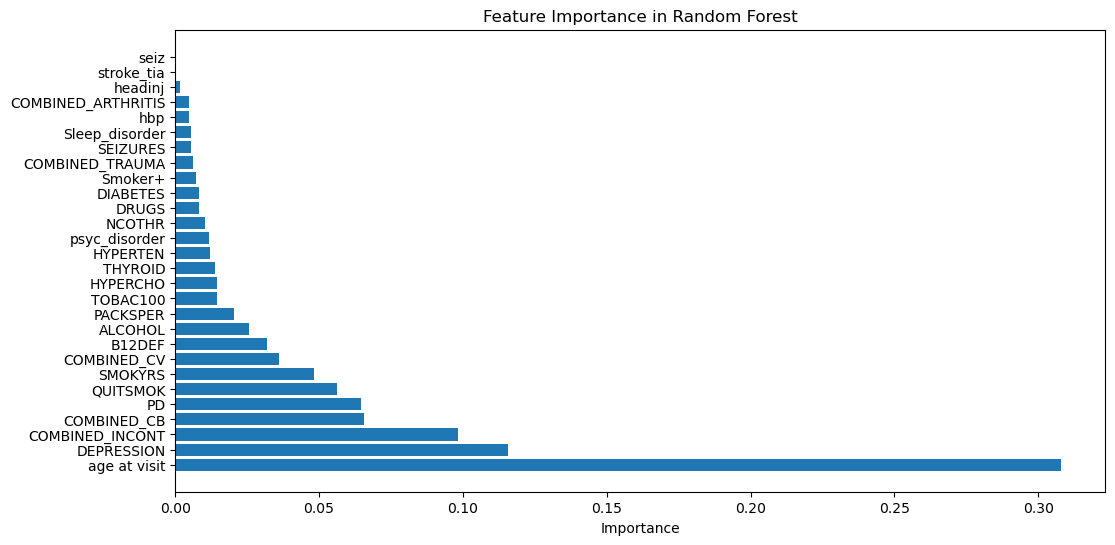

In [115]:

X=health1.drop(["Outcome"], axis=1)
y=health1['Outcome'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# Entrena el clasificador
rf_classifier.fit(X_train, y_train)

# Realiza predicciones en el conjunto de prueba
predictions = rf_classifier.predict(X_test)

# Evalúa la precisión del modelo
accuracy = accuracy_score(y_test, predictions)
print(f'Precisión del modelo: {accuracy * 100:.2f}%')

# Obtener la importancia de las variables
feature_importance = rf_classifier.feature_importances_

# Crear un DataFrame para visualizar mejor la importancia de las variables
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Ordenar el DataFrame por importancia de las variables en orden descendente
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualizar la importancia de las variables
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest')
plt.show()



In [116]:
### Remove the variables with less importance and more number of 0
health1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8499 entries, 0 to 8498
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age at visit        8499 non-null   float64
 1   PD                  8499 non-null   float64
 2   SEIZURES            8499 non-null   float64
 3   NCOTHR              8499 non-null   float64
 4   HYPERTEN            8499 non-null   float64
 5   HYPERCHO            8499 non-null   float64
 6   DIABETES            8499 non-null   float64
 7   B12DEF              8499 non-null   float64
 8   THYROID             8499 non-null   float64
 9   ALCOHOL             8499 non-null   float64
 10  TOBAC100            8499 non-null   float64
 11  SMOKYRS             8499 non-null   float64
 12  PACKSPER            8499 non-null   float64
 13  QUITSMOK            8499 non-null   float64
 14  stroke_tia          8499 non-null   float64
 15  hbp                 8499 non-null   float64
 16  seiz  

We remove the variables that have less importance for the model, according to the graph that we can see above. As we observe, many of the variables with less importance also coincide with a higher number of 0.

In [117]:
health.drop(['stroke_tia', 'hbp', 'seiz', 'headinj', "Smoker+", "SEIZURES", "NCOTHR", "Sleep_disorder", "COMBINED_ARTHRITIS", "psyc_disorder" ], axis=1, inplace=True)

We calculate again the percentage of 0.

In [119]:
#calculate the percentage of 0
total_zeros = (health == 0).sum().sum()
total_elements = health.size
percentage_zeros = (total_zeros / total_elements) * 100

print(f"Porcentaje total de valores 0 en el dataset: {percentage_zeros:.2f}%")

Porcentaje total de valores 0 en el dataset: 41.31%


## 2.2.2. Dataset "globaldata"

### We create the column "Mood disorder"

In this dataframe, there is a column called 'dx2' where all are strings of different patient diseases. Since we already have the dataframe "health" with the clinical history, we keep only the 'Mood disorder' that does not appear in the 'health' dataframe and is also the most complete category (with fewer NaNs).

In [103]:
globaldata['mood_disorder'] = np.where((globaldata['dx2'] == 'Active Mood disorder') | (globaldata['dx2'] == 'Remote Mood disorder'), 1, 0)

# 2.3. Merge of dataset "health" and "globaldata"

We have kept all the columns from the 'health' dataframe and only those from the 'globaldata' dataframe that had a 1 in the 'Outcome' and were not in 'health'. In total, we added 31 rows more with 'Outcome' 1.

In [272]:
df_merged = pd.merge(health, globaldata, on=['OASISID','age at visit','days_to_visit'], how='inner')

In [273]:
# Create a mask for rows in globaldata where Outcome is 0 and OASISID is not in health
mask = (globaldata['Outcome'] == 1) & (~globaldata['OASISID'].isin(health['OASISID']))

# Include rows from df_merged based on the mask
df_merged1 = pd.concat([df_merged, globaldata[mask]], ignore_index=True)

In [274]:
health["OASISID"].nunique()

1340

In [275]:
df_merged1["OASISID"].nunique()

1371

In [276]:
df_merged1.head()

,OASISID,OASIS_session_label_x,days_to_visit,age at visit,PD,HYPERTEN,HYPERCHO,DIABETES,B12DEF,THYROID,ALCOHOL,TOBAC100,SMOKYRS,PACKSPER,QUITSMOK,COMBINED_CV,COMBINED_CB,COMBINED_TRAUMA,COMBINED_INCONT,DEPRESSION,DRUGS,OASIS_session_label_y,MMSE,memory,orient,judgment,commun,homehobb,perscare,CDRSUM,CDRTOT,dx1_code,dx2_code,dx3_code,dx4_code,dx5_code,dx1,dx2,dx3,dx4,dx5,Outcome,mood_disorder,OASIS_session_label
0,OAS30001,OAS30001_UDSa5_d0000,0,65.19,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,OAS30001_UDSb4_d0000,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,Cognitively normal,.,.,.,.,0,0,NaN
1,OAS30001,OAS30001_UDSa5_d0339,339,66.12,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,OAS30001_UDSb4_d0339,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,Cognitively normal,.,.,.,.,0,0,NaN
2,OAS30001,OAS30001_UDSa5_d0722,722,67.17,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,OAS30001_UDSb4_d0722,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,Cognitively normal,.,.,.,.,0,0,NaN
3,OAS30001,OAS30001_UDSa5_d1106,1106,68.22,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OAS30001_UDSb4_d1106,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,Cognitively normal,.,.,.,.,0,0,NaN
4,OAS30001,OAS30001_UDSa5_d1456,1456,69.18,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OAS30001_UDSb4_d1456,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,Cognitively normal,.,.,.,.,0,0,NaN


### Removal of columns

We remove the columns from "globaldata" that are not relevant for the model or that are linked to our target variable. For example, "CDRSUM" is the variable that we used to obtain the final column "Outcome" with 1: Dementia and 0: non dementia. 

In [277]:
df_merged1.drop(["dx1","dx2","dx3", "dx4", "dx5", "dx1_code", "CDRSUM", "CDRTOT", "dx2_code", "dx3_code", "dx4_code", "dx5_code", "OASIS_session_label", "OASIS_session_label_x", "OASIS_session_label_y", "days_to_visit" ], axis=1, inplace=True)

### Removal of columns that are linked to our target variable.

Note that the feature CDRSUM is actually the sum of the scores of six features including MEMORY, ORIENT, JUDGMENT, COMMUN, HOMEHOBB, PERSCARE. Therefore, HOMEHOBB, COMMUN, ORIENT, and JUDGMENT as independent features are ones that substantially will impact the model performance. 

In [278]:
df_merged1.drop(['memory', 'orient','homehobb', 'perscare', 'judgment', 'commun'], axis=1, inplace=True)

In [279]:
#we check the percentage that we have now of 0. 
df_merged1.fillna(0, inplace=True)
total_zeros = (df_merged1 == 0).sum().sum()
total_elements = df_merged1.size
percentage_zeros = (total_zeros / total_elements) * 100

print(f"Porcentaje total de valores 0 en el dataset: {percentage_zeros:.2f}%") #it has increased as we had added more columns

Porcentaje total de valores 0 en el dataset: 74.21%


# 2.4. Dataset about demographics

In [280]:
#first we add the columns from the dataset of demographics
df_merged2 = pd.merge(df_merged1, demo, on=['OASISID'], how='inner')
df_merged2.head()

,OASISID,age at visit,PD,HYPERTEN,HYPERCHO,DIABETES,B12DEF,THYROID,ALCOHOL,TOBAC100,SMOKYRS,PACKSPER,QUITSMOK,COMBINED_CV,COMBINED_CB,COMBINED_TRAUMA,COMBINED_INCONT,DEPRESSION,DRUGS,MMSE,Outcome,mood_disorder,Subject_accession,AgeatEntry,AgeatDeath,GENDER,EDUC,SES,racecode,race,ETHNIC,AIAN,NHPI,ASIAN,AA,WHITE,daddem,momdem,HAND,APOE
0,OAS30001,65.19,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,0,0,NaN,65.1945,NaN,2,12.0,4.0,5,White,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,R,23.0
1,OAS30001,66.12,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,0,0,NaN,65.1945,NaN,2,12.0,4.0,5,White,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,R,23.0
2,OAS30001,67.17,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,30.0,0,0,NaN,65.1945,NaN,2,12.0,4.0,5,White,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,R,23.0
3,OAS30001,68.22,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0,0,NaN,65.1945,NaN,2,12.0,4.0,5,White,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,R,23.0
4,OAS30001,69.18,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0,0,NaN,65.1945,NaN,2,12.0,4.0,5,White,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,R,23.0


In [281]:
#we drop the columns that are not relevant or that we have already obtained the info.
df_merged2.drop(['Subject_accession', 'AgeatEntry', 'AgeatDeath','race', 'ETHNIC', 'AIAN', 'NHPI', 'ASIAN',
       'AA', 'WHITE'], axis=1, inplace=True)

In [282]:
#we get dummies from the column with strings
df_dummy = pd.get_dummies(df_merged2['HAND'], prefix='Hand', drop_first=True)
df_dummy = df_dummy.astype(int)

# we add the new columns to the dataframe
df_merged2 = pd.concat([df_merged2, df_dummy], axis=1)

# Delete the column with strings
df_merged2.drop('HAND', axis=1, inplace=True)


In [283]:
#we check again the percentage of 0-it has decreased
df_merged2.fillna(0, inplace=True)
total_zeros = (df_merged2 == 0).sum().sum()
total_elements = df_merged2.size
percentage_zeros = (total_zeros / total_elements) * 100

print(f"Porcentaje total de valores 0 en el dataset: {percentage_zeros:.2f}%")

Porcentaje total de valores 0 en el dataset: 59.84%


# 2.5 Exploratory Visualization

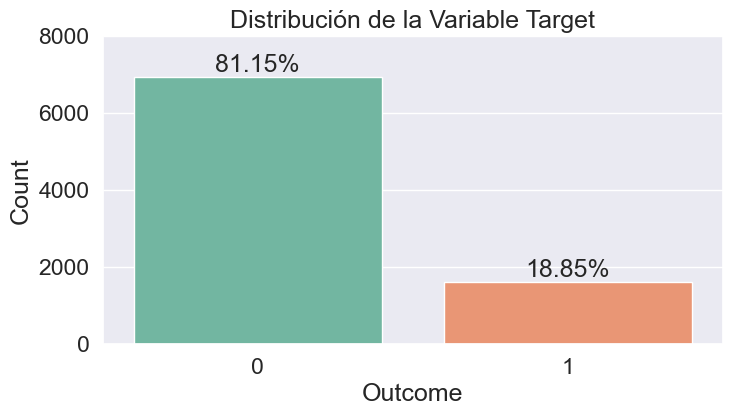

In [161]:
# Create a graphic to see the distribution of targets
targets = df_merged2['Outcome'].values

sns.set(font_scale=1.5)
plt.figure(figsize=(8, 4))

#countplot
ax = sns.countplot(x=targets, palette="Set2")

# Labels
ax.set_xlabel('Outcome')
ax.set_ylabel('Count')
ax.set_ylim(top=8000)

# Percentage
for p in ax.patches:
    height = p.get_height()
    ax.annotate('{:.2f}%'.format(100 * height / len(targets)),
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')
plt.title('Distribución de la Variable Target')
plt.show()


**The plot shows that:**

- the target is imbalanced
- high bias is expected to 0
- class weight has to be balanced on training

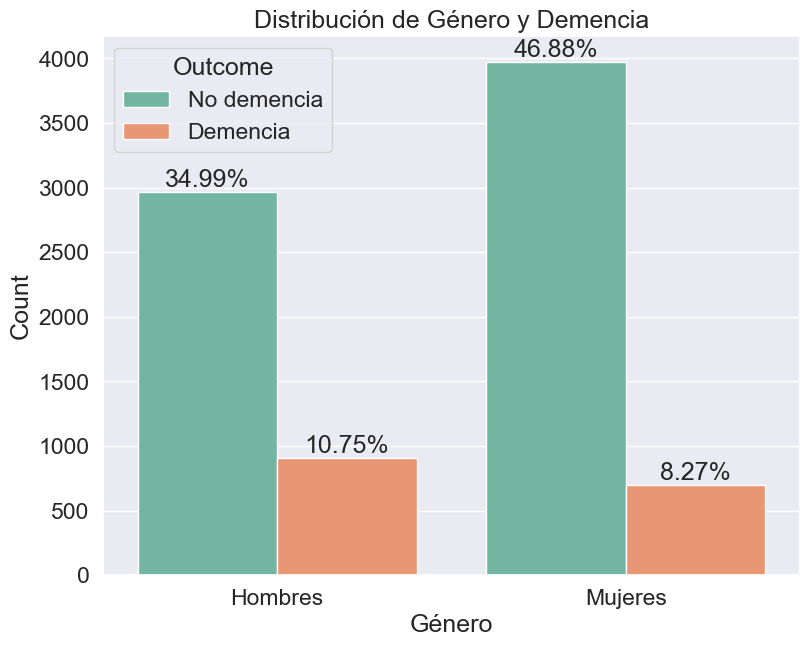

In [180]:
# Create a graphic to see the distribution of targets and gender
sns.set(font_scale=1.5)
plt.figure(figsize=(9, 7))

#Gender
ax = sns.countplot(x='GENDER', hue='Outcome', data=df_merged2, palette="Set2", order=[1, 2])

# Labels
ax.set_xlabel('Género')
ax.set_ylabel('Count')
plt.title('Distribución de Género y Demencia')

# Percentage
total = float(len(df_merged))
for p in ax.patches:
    height = p.get_height()
    ax.annotate('{:.2f}%'.format(100 * height / total),
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')
ax.legend(title='Outcome', labels=['No demencia', 'Demencia'])
ax.set_xticklabels(['Hombres', 'Mujeres'])

plt.show()


**The plot shows that:**
    
- There are more men than women with dementia, but the difference is minimal
- We do not expect this variable to have a great importance for the model.

**Age, MMSE and dementia**

The Mini-Mental State Examination (MMSE) measures general cognitive status, with scores ranging from 0 (severe impairment to 30 (no impairment).

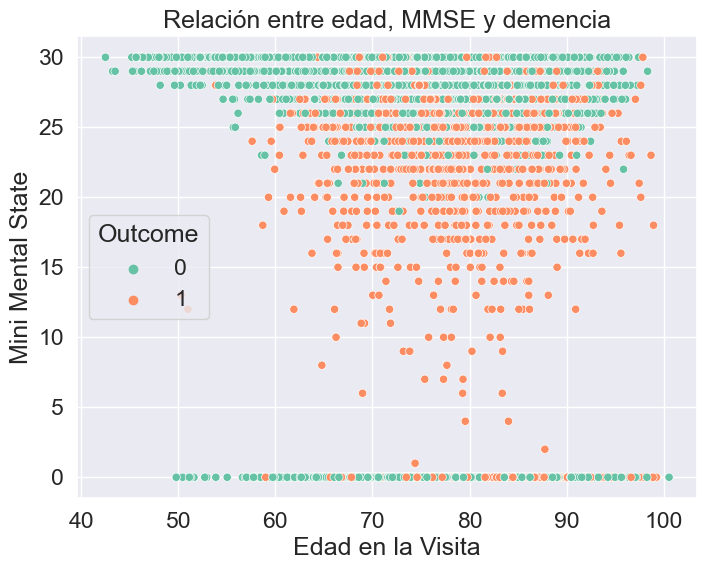

In [198]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='age at visit', y='MMSE', hue='Outcome', data=df_merged2, palette='Set2')
plt.title('Relación entre edad, MMSE y demencia')
plt.xlabel('Edad en la Visita')
plt.ylabel('Mini Mental State')
plt.show()

**The plot shows that:**
    
- The subjects with dementia show a worst state of MMSE.
- We expect this variable to be correlated with our target variable.
- We observe that there are older subjects with dementia.

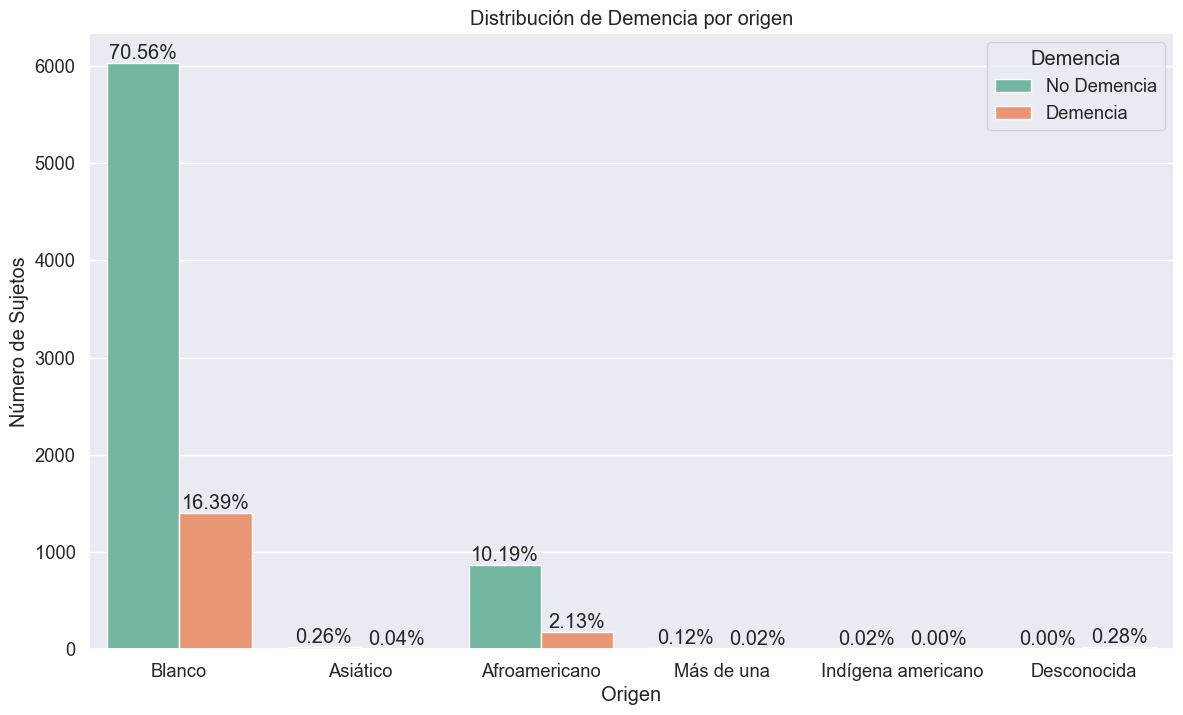

In [294]:

# Mapping of the race code
race_mapping = {
    0: "Desconocida",
    1: 'Indígena americano',
    2: 'Asiático',
    4: 'Afroamericano',
    5: 'Blanco',
    6: "Más de una",
}

# Mapping of "outcome"
outcome_mapping = {
    0: "No Demencia",
    1: "Demencia",
}

# style and size
sns.set(font_scale=1.2)
plt.figure(figsize=(14, 8))

# Creation of countplot
ax = sns.countplot(x=df_merged2['racecode'].map(race_mapping), hue=df_merged2['Outcome'].map(outcome_mapping), palette="Set2")

# labls
ax.set_xlabel('Origen')
ax.set_ylabel('Número de Sujetos')
plt.title('Distribución de Demencia por origen')

# Percentage
total = float(len(df_merged2))
for p in ax.patches:
    height = p.get_height()
    ax.annotate('{:.2f}%'.format(100 * height / total),
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

# Legend
ax.legend(title='Demencia')

plt.show()


**The plot shows that:**
- The data is not sufficient to observe a correlation between race and dementia

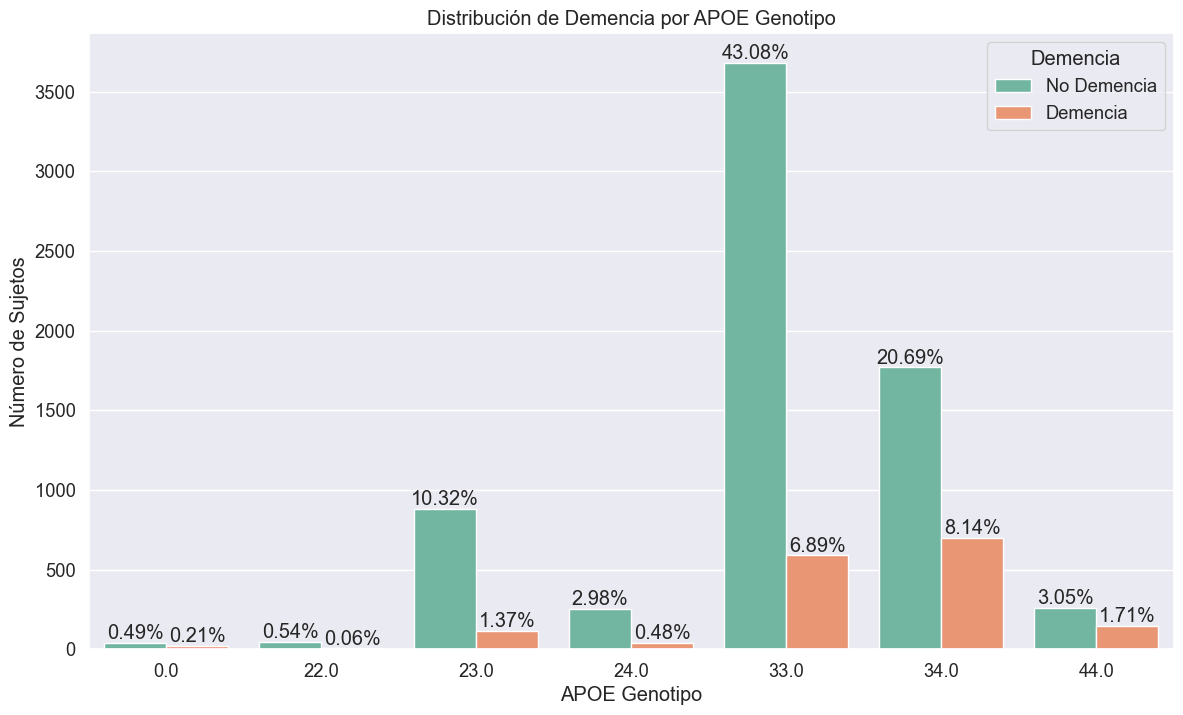

In [295]:

# Mapeo de códigos de demencia a nombres
outcome_mapping = {
    0: "No Demencia",
    1: "Demencia",
}

# Configuración de estilos y tamaño de la figura
sns.set(font_scale=1.2)
plt.figure(figsize=(14, 8))

# Crear el countplot
ax = sns.countplot(x=df_merged2['APOE'], hue=df_merged2['Outcome'].map(outcome_mapping), palette="Set2")

# Configuraciones adicionales
ax.set_xlabel('APOE Genotipo')
ax.set_ylabel('Número de Sujetos')
plt.title('Distribución de Demencia por APOE Genotipo')

# Añadir etiquetas de porcentajes encima de las barras
total = float(len(df_merged2))
for p in ax.patches:
    height = p.get_height()
    ax.annotate('{:.2f}%'.format(100 * height / total),
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

# Cambiar etiquetas en la leyenda
ax.legend(title='Demencia')

plt.show()


The allelic combinations that have been associated with a higher risk in relation to Alzheimer's disease are 34 and 44. Something we can see in this graph regarding allele 34.

### Correlation matrix

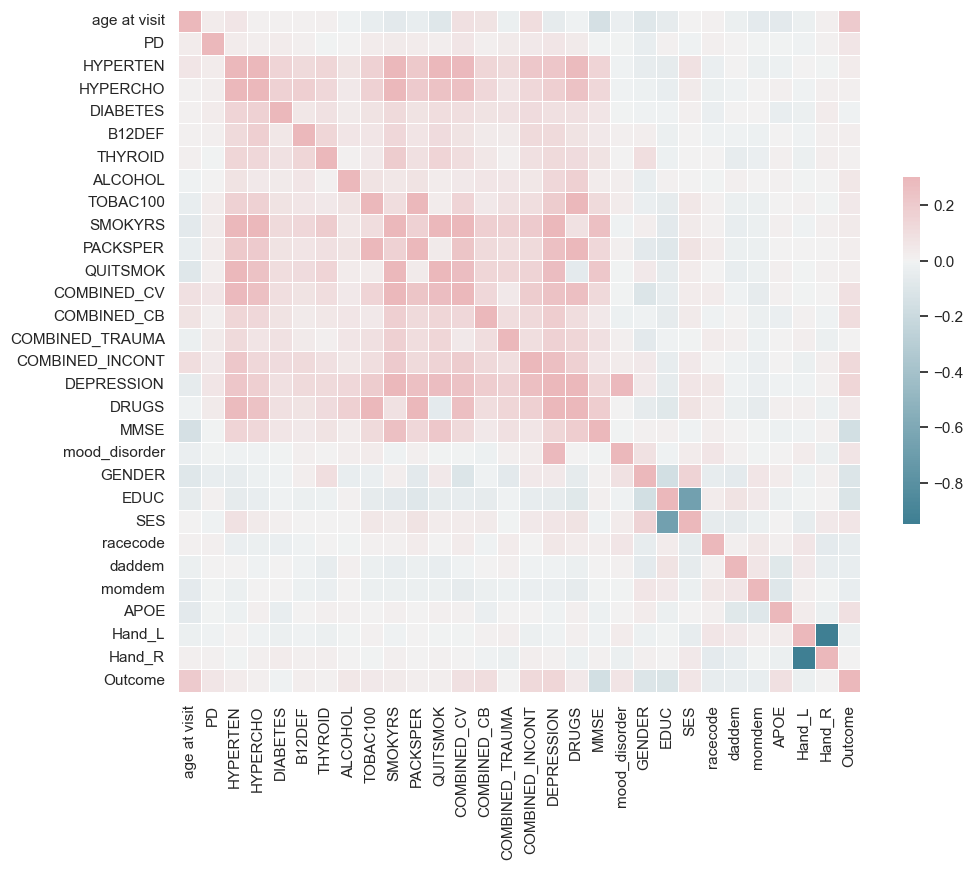

In [205]:
numeric_variables = ['age at visit', 'PD', 'HYPERTEN', 'HYPERCHO', 'DIABETES',
       'B12DEF', 'THYROID', 'ALCOHOL', 'TOBAC100', 'SMOKYRS', 'PACKSPER',
       'QUITSMOK', 'COMBINED_CV', 'COMBINED_CB', 'COMBINED_TRAUMA',
       'COMBINED_INCONT', 'DEPRESSION', 'DRUGS', 'MMSE',
       'mood_disorder', 'GENDER', 'EDUC', 'SES', 'racecode', 'daddem',
       'momdem', 'APOE', 'Hand_L', 'Hand_R' ]
all_variables = numeric_variables + ['Outcome']

# Filtrar solo las variables relevantes
correlation_df = df_merged2[all_variables]

# Calcular la matriz de correlación
corr= correlation_df.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In the correlation matrix, we can see that there is no variable that is highly correlated with the target variable. However, we can observe that there are variables in the 'health' dataset that are correlated with each other, which may lead to **multicollinearity**. As they are providing redundant information to the model, we will remove some of them later. Removing them would prevent also the curse of dimensionality

In [422]:
df_merged3 = df_merged2.copy()
df_merged3.drop(["OASISID"], axis=1, inplace=True)
data_a_dibujar= df_merged3
correlation_triu = data_a_dibujar.corr().where(np.triu(np.ones(data_a_dibujar.corr().shape), k=1).astype(bool))      #La función np.triu trianguliza la matriz superior dado que es simétrica y se obtendrían las parejas de variables repetidas.
correlation_pairs = correlation_triu.unstack().sort_values(ascending=False)
top_correlation_pairs = correlation_pairs[correlation_pairs < 1]#.head(5)
print('')
print('Parejas de variables con correlación ordenadas de mayor a menor:')
print('')
print(round(top_correlation_pairs.head(50), 4))


Parejas de variables con correlación ordenadas de mayor a menor:

DRUGS            TOBAC100           0.8232
                 PACKSPER           0.7586
                 SMOKYRS            0.7177
PACKSPER         SMOKYRS            0.6953
                 TOBAC100           0.6603
SMOKYRS          TOBAC100           0.6221
HYPERCHO         HYPERTEN           0.5181
COMBINED_CV      HYPERCHO           0.4373
                 HYPERTEN           0.3888
DRUGS            HYPERCHO           0.3714
                 HYPERTEN           0.3661
DEPRESSION       HYPERTEN           0.3199
TOBAC100         HYPERCHO           0.3145
DRUGS            DEPRESSION         0.3140
TOBAC100         HYPERTEN           0.3094
SMOKYRS          HYPERTEN           0.3083
PACKSPER         HYPERCHO           0.3038
SMOKYRS          HYPERCHO           0.3026
DEPRESSION       HYPERCHO           0.2991
PACKSPER         HYPERTEN           0.2975
DRUGS            ALCOHOL            0.2945
DIABETES         HYPERTEN     

# 3. First  model: Random forest (30 features)

In [301]:
df_merged2["Outcome"].value_counts()

Outcome
0    6938
1    1612
Name: count, dtype: int64

In [370]:
df_merged3 = df_merged2.copy()
df_merged3.drop(["OASISID"], axis=1, inplace=True)

In [371]:
X=df_merged3.drop(["Outcome"], axis=1)
y=df_merged3['Outcome'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Predictions
predictions = rf_classifier.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, predictions)
print(f'Precisión del modelo: {accuracy * 100:.2f}%')

Precisión del modelo: 84.50%


In [372]:
# Metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)

Accuracy: 0.8450
Precision: 0.7791
Recall: 0.2141
F1 Score: 0.3358

Confusion Matrix:
 [[1378   19]
 [ 246   67]]


-**Interpretation**:

- The model is doing well in correctly predicting cases without dementia and correctly predicting cases with dementia (high true positives).
- However, the model is less effective at capturing all actual positive instances (dementia cases), as evidenced by the relatively low recall of 21.78%. This means that a substantial portion of actual dementia cases is being missed by the model and interpret as non-dementia.

**Recall (Sensitivity)**: It is the ratio of correctly predicted positive observations to all actual positives. In your case, recall is calculated as TP / (TP + FN), which is approximately 67 / (67 + 246) = 0.2478 or 24.78%.

- True Negatives (TN): These are cases where the model correctly identified individuals without dementia. There are 1378 instances where the model correctly predicted non-dementia, and these predictions are considered true.
- False Positives (FP): These are cases where the model predicted dementia, but the individuals do not actually have dementia. There are 19 instances where the model made a false prediction of dementia.
- False Negatives (FN): These are cases where the model predicted non-dementia, but the individuals actually have dementia. There are 246 instances where the model failed to identify dementia cases.
- True Positives (TP): These are cases where the model correctly identified individuals with dementia. There are 67 instances where the model correctly predicted dementia.

In summary, while the model has a high accuracy, it seems to struggle with recall, indicating that it misses a significant number of actual positive instances. In medical diagnosis, missing a positive case (false negative) can have serious consequences, as it means failing to identify a patient with a condition that requires attention.

### Feature importance

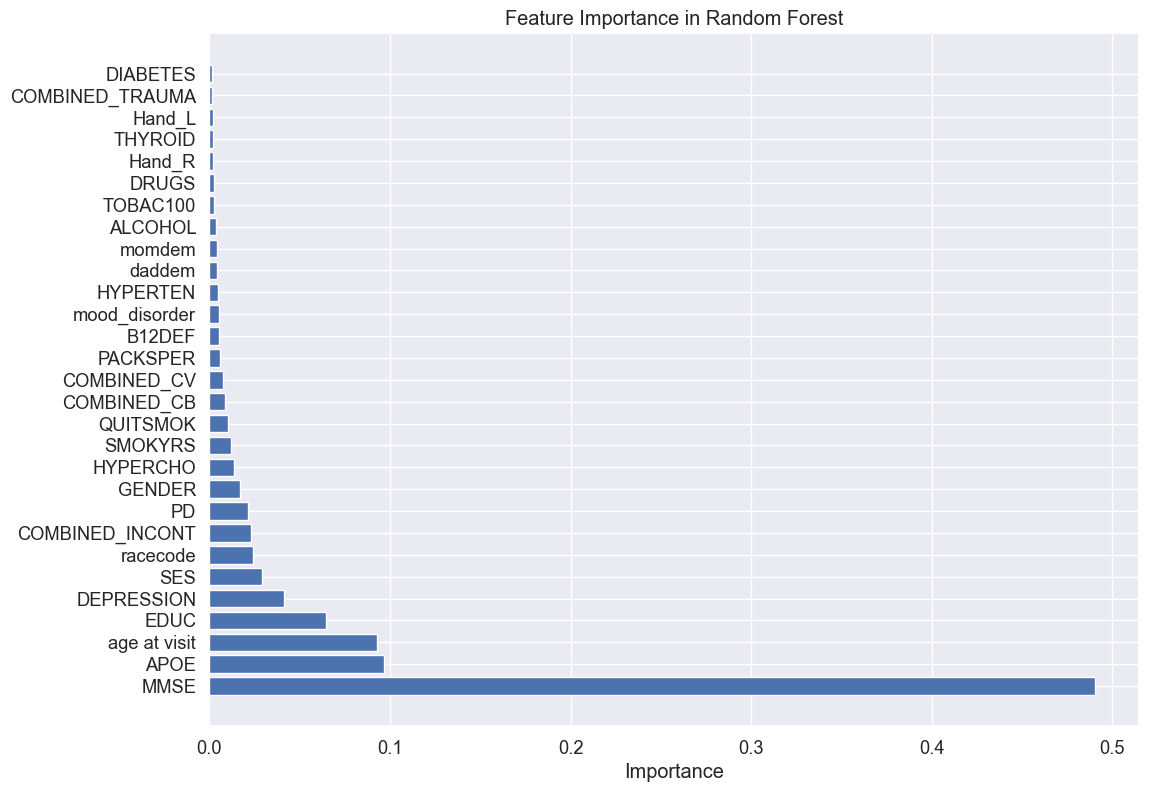

In [323]:
import matplotlib.pyplot as plt

# Obtain feature importances
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame with feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 9))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest')
plt.show()


**Remove variables and test the model again (23 features)**

In [331]:
df_merged3.drop(["DIABETES", "COMBINED_TRAUMA", "Hand_L", "THYROID", "Hand_R", "DRUGS", "TOBAC100"], axis=1, inplace=True)

In [332]:
X=df_merged3.drop(["Outcome"], axis=1)
y=df_merged3['Outcome'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Predictions
predictions = rf_classifier.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, predictions)
print(f'Precisión del modelo: {accuracy * 100:.2f}%')

Precisión del modelo: 85.03%


In [333]:
#Predictions for the test
y_pred = rf_classifier.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)

Accuracy: 0.8503
Precision: 0.8667
Recall: 0.2090
F1 Score: 0.3368

Confusion Matrix:
 [[1389   10]
 [ 246   65]]


Recall and F1 score still not better yet. This is probably because the dataset is imbalanced. That is why we are going to use now different techniques to balance the df.

# 4. Second model: Random forest and under/over sampling. (30 features)

In the context of Alzheimer detection, we would like to maximize the true positive rate and capture as many Alzheimer cases as possible, so **recall for the minority class** is the metric we would like to optimize.

In [398]:
df_merged4 = df_merged2.copy()
df_merged4.drop(["OASISID"], axis=1, inplace=True)

In [399]:
# Train test split
X=df_merged4.drop(["Outcome"], axis=1)
y=df_merged4['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Check the number of records
print('The number of records in the training dataset is', X_train.shape[0])
print('The number of records in the test dataset is', X_test.shape[0])
print(f"The training dataset has {sorted(Counter(y_train).items())[0][1]} records for the majority class and {sorted(Counter(y_train).items())[1][1]} records for the minority class.")

The number of records in the training dataset is 6840
The number of records in the test dataset is 1710
The training dataset has 5561 records for the majority class and 1279 records for the minority class.


**Baseline Random Forest Model for Imbalanced Data**
We first check the model performance using the imbalanced data directly and using a baseline random forest without adding hyperparameter tuning.

In [376]:
# Train the random forest model
rf = RandomForestClassifier(random_state=42)
baseline_model = rf.fit(X_train, y_train)
baseline_prediction = baseline_model.predict(X_test)
# Check the model performance
print(classification_report(y_test, baseline_prediction))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      1397
           1       0.82      0.62      0.70       313

    accuracy                           0.90      1710
   macro avg       0.87      0.79      0.82      1710
weighted avg       0.90      0.90      0.90      1710



From the classification report we can observe that the **model improves when no hyperparameters are used.**

### RandomUndersampler

In [400]:
# Randomly under sample the majority class
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus= rus.fit_resample(X_train, y_train)
# Check the number of records after under sampling
print(sorted(Counter(y_train_rus).items()))

[(0, 1279), (1, 1279)]


In [401]:
# Train the random forest model
# rf = RandomForestClassifier()
rus_model = rf.fit(X_train_rus, y_train_rus)
rus_prediction = rus_model.predict(X_test)
# Check the model performance
print(classification_report(y_test, rus_prediction))

              precision    recall  f1-score   support

           0       0.96      0.83      0.89      1377
           1       0.55      0.84      0.66       333

    accuracy                           0.83      1710
   macro avg       0.75      0.84      0.78      1710
weighted avg       0.88      0.83      0.85      1710



In [402]:
# Calcular métricas
accuracy = accuracy_score(y_test, rus_prediction)
precision = precision_score(y_test, rus_prediction)
recall = recall_score(y_test, rus_prediction)
f1 = f1_score(y_test, rus_prediction)
conf_matrix = confusion_matrix(y_test, rus_prediction)

# Imprimir resultados
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)

Accuracy: 0.8339
Precision: 0.5481
Recall: 0.8378
F1 Score: 0.6627

Confusion Matrix:
 [[1147  230]
 [  54  279]]


### RandomOverSampler

In [403]:
# Randomly over sample the minority class
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros= ros.fit_resample(X_train, y_train)
# Check the number of records after over sampling
print(sorted(Counter(y_train_ros).items()))

[(0, 5561), (1, 5561)]


In [404]:
# Train the random forest model
# rf = RandomForestClassifier()
ros_model = rf.fit(X_train_ros, y_train_ros)
ros_prediction = ros_model.predict(X_test)
# Check the model performance
print(classification_report(y_test, ros_prediction))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1377
           1       0.79      0.68      0.73       333

    accuracy                           0.90      1710
   macro avg       0.86      0.82      0.83      1710
weighted avg       0.90      0.90      0.90      1710



In [405]:
# Calcular métricas
accuracy = accuracy_score(y_test, ros_prediction)
precision = precision_score(y_test, ros_prediction)
recall = recall_score(y_test, ros_prediction)
f1 = f1_score(y_test, ros_prediction)
conf_matrix = confusion_matrix(y_test, ros_prediction)

# Imprimir resultados
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)

Accuracy: 0.9018
Precision: 0.7875
Recall: 0.6787
F1 Score: 0.7290

Confusion Matrix:
 [[1316   61]
 [ 107  226]]


**In this two models (under and oversampling) it can be seen that:**
- **Undersampling**: The model performs well in terms of recall (sensitivity), meaning it is good at capturing true positive cases. However, precision is relatively lower, indicating that there may be more false positives. This could be a trade-off between correctly identifying positive cases and having a higher number of false alarms.
- **Oversampling**: The model has a higher accuracy and precision, suggesting better overall performance and fewer false positives(people without dementia are classified as having it). However, recall is somewhat lower compared to the undersampled case, indicating that it might miss some positive cases.

**Considerations:**
- **Recall (Sensitivity)**: In the context of Alzheimer's detection, capturing as many positive cases as possible (high recall) might be crucial, as missing a positive case could have serious consequences.
- **Precision**: Balancing precision is also important, especially if false positives have significant consequences or lead to unnecessary interventions.
- **F1 Score**: It combines precision and recall, providing a balanced metric. If both false positives and false negatives are equally important, F1 Score can be a good choice.

### Roc-AUC for over-sampling

In [406]:
y_pred_prob = ros_model.predict_proba(X_test)[:, 1]  # Obtain probabilities of the positive class

# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, ros_prediction)

print("AUC-ROC Score:", auc_roc)


AUC-ROC Score: 0.8171897387583662


### Roc-AUC for under-sampling

In [407]:
y_pred_prob = rus_model.predict_proba(X_test)[:, 1]  # Obtain probabilities of the positive class

# Calculate AUC-ROC
auc_roc = roc_auc_score(y_test, rus_prediction)

print("AUC-ROC Score:", auc_roc)

AUC-ROC Score: 0.8354040314824628


## 4.1. Overview

In [485]:
# define an auxiliary function that plots the results according to the specified model.
def funcionpro(model):

    if model==rus:
        nombre='Random Forest Undersampler'
        y_pred_test=rus_prediction 
    elif model==ros:
        nombre='Random Forest Oversampler'
        y_pred_test=ros_prediction


    print(nombre)
    # Show the result of the metrics
    print('')
    print('Accuracy score:', round(accuracy_score(y_test,y_pred_test), 4))
    print('Confusion matrix:')


    # Simple confusion matrix.
    #print(confusion_matrix(y_test, y_pred_test))


    # More aesthetic confusion matrix
    cm = sns.light_palette("lightblue", as_cmap=True)
    x1=pd.DataFrame(confusion_matrix(y_test, y_pred_test))
    vmin1=confusion_matrix(y_test, y_pred_test).min()
    vmax1=confusion_matrix(y_test, y_pred_test).max()
    x1=x1.style.background_gradient(cmap=cm, vmin=vmin1, vmax=vmax1)
    display(x1)
    report = classification_report(y_test, y_pred_test, target_names=['Dementia', 'Non dementia'], output_dict=True)
    print('')
    df_report = pd.DataFrame(report).transpose().round(4)
    df_report.drop(['accuracy', 'macro avg', 'weighted avg'], inplace=True)

    # Format the table using tabulate
    table = tabulate(df_report, headers='keys', tablefmt='grid')


    # Imprimir la tabla
    print('')
    print(table)
    print('')
    print('')
    print('-------------------------------------------------------------------')
    print('')
    print('')

In [484]:
funcionpro(rus)
funcionpro(ros)

Random Forest Undersampler

Accuracy score: 0.8339
Confusion matrix:


,0,1
0,1147,230
1,54,279




+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
+==============+=============+==========+============+===========+
| Dementia     |      0.955  |   0.833  |     0.8898 |      1377 |
+--------------+-------------+----------+------------+-----------+
| Non dementia |      0.5481 |   0.8378 |     0.6627 |       333 |
+--------------+-------------+----------+------------+-----------+



-------------------------------------------------------------------


Random Forest Oversampler

Accuracy score: 0.9018
Confusion matrix:


,0,1
0,1316,61
1,107,226




+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
+==============+=============+==========+============+===========+
| Dementia     |      0.9248 |   0.9557 |      0.94  |      1377 |
+--------------+-------------+----------+------------+-----------+
| Non dementia |      0.7875 |   0.6787 |      0.729 |       333 |
+--------------+-------------+----------+------------+-----------+



-------------------------------------------------------------------




# 5. XGboost with stratified sampling

In order to have a better balance between precision and accuracy, we try also XGboost with stratified sampling. XGBoost offers the option of stratified sampling using the **DMatrix library**. This helps in taking a balanced sample for each iteration of the training.

In [440]:
df_merged5 = df_merged2.copy()
df_merged5.drop(["OASISID"], axis=1, inplace=True)

In [492]:
X=df_merged5.drop(["Outcome"], axis=1)
y=df_merged5['Outcome'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False  
}
num_rounds = 100  # Number of training rounds
model1 = xgb.train(params, dtrain, num_rounds)
y_pred_proba = model1.predict(dtest)
y_pred1 = [1 if proba >= 0.5 else 0 for proba in y_pred_proba]

accuracy = accuracy_score(y_test, y_pred1)
print("Accuracy on Test Set:", accuracy)

print("\nClassification Report:\n", classification_report(y_test, y_pred1))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred1))

Accuracy on Test Set: 0.8976608187134503

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94      1377
           1       0.82      0.61      0.70       333

    accuracy                           0.90      1710
   macro avg       0.86      0.79      0.82      1710
weighted avg       0.89      0.90      0.89      1710


Confusion Matrix:
 [[1332   45]
 [ 130  203]]


/Users/lauradiazmunozmanzanares/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:49:07] WARNING: /private/var/folders/7y/zsyp5rf118nddtsysc4h19h00000gn/T/pip-install-m76ggad_/xgboost_25749e648657441ab762f606448aa50e/cpp_src/src/learner.cc:742: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [493]:
# Calcular métricas
accuracy = accuracy_score(y_test, y_pred1)
precision = precision_score(y_test, y_pred1)
recall = recall_score(y_test, y_pred1)
f1 = f1_score(y_test, y_pred1)
conf_matrix = confusion_matrix(y_test, y_pred1)

# Imprimir resultados
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)

Accuracy: 0.8977
Precision: 0.8185
Recall: 0.6096
F1 Score: 0.6988

Confusion Matrix:
 [[1332   45]
 [ 130  203]]


### Roc-auc

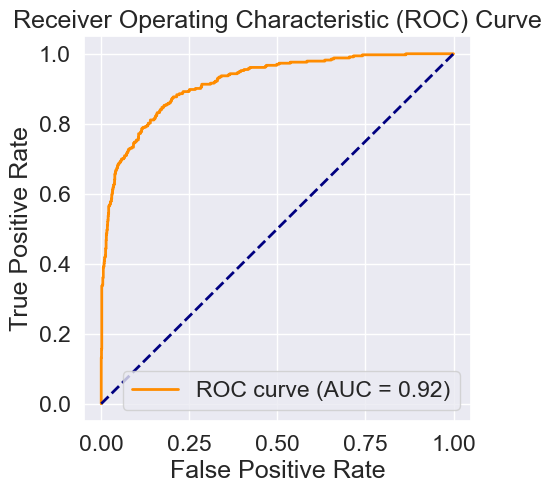

In [459]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calcular el área bajo la curva ROC (AUC-ROC)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

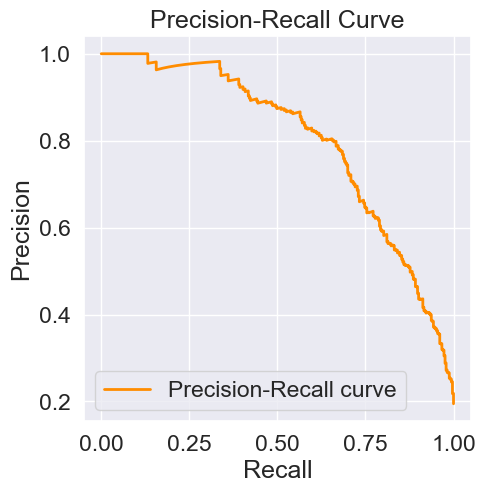

In [444]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(5, 5))
plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()



In [416]:
predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred1})
predictions_df.head(20)

,Actual,Predicted
1558,0,0
8167,0,0
5551,0,0
4626,0,0
623,0,0
1298,0,0
5991,0,0
2718,0,0
1111,0,0
7320,0,0


## XGboost: Muestreo estratificado-umbral 0.3 - 'scale_pos_weight': 2

- We **lower the threshold** meaning that if the predicted probability of the positive class is equal to or greater than 0.3, the instance is classified as positive. The main purpose is to have more instances predicted as positive, which increase the recall but may come at the expense of precision.
- The **scale_pos_weight hyperparameter** is used to address class imbalance. By adjusting scale_pos_weight, we assign more importance to the minority class, helping the model give it more weight during training. 

In our case, we set scale_pos_weight to **2**, which means the positive class is given twice the weight of the negative class.

In [423]:
# Calculate the number of positive instances for each class
num_positives = np.sum(df_merged3['Outcome'] == 1)
num_negatives = np.sum(df_merged3['Outcome'] == 0)

# Calculate scale_pos_weight using the square root
np.sqrt(num_negatives / num_positives)

2.0746012203132103

In [494]:
X=df_merged5.drop(["Outcome"], axis=1)
y=df_merged5['Outcome'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'scale_pos_weight': 2
}
num_rounds = 100  
model2 = xgb.train(params, dtrain, num_rounds)
y_pred_proba = model2.predict(dtest)
y_pred2 = [1 if proba >= 0.3 else 0 for proba in y_pred_proba] #we lower the threshold from 0.5 to 0.3

accuracy = accuracy_score(y_test, y_pred2)
print("Accuracy on Test Set:", accuracy)

print("\nClassification Report:\n", classification_report(y_test, y_pred2))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred2))

Accuracy on Test Set: 0.8678362573099415

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.89      0.92      1377
           1       0.63      0.77      0.69       333

    accuracy                           0.87      1710
   macro avg       0.79      0.83      0.81      1710
weighted avg       0.88      0.87      0.87      1710


Confusion Matrix:
 [[1227  150]
 [  76  257]]


/Users/lauradiazmunozmanzanares/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:49:57] WARNING: /private/var/folders/7y/zsyp5rf118nddtsysc4h19h00000gn/T/pip-install-m76ggad_/xgboost_25749e648657441ab762f606448aa50e/cpp_src/src/learner.cc:742: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [496]:
# Calcular métricas
accuracy = accuracy_score(y_test, y_pred2)
precision = precision_score(y_test, y_pred2)
recall = recall_score(y_test, y_pred2)
f1 = f1_score(y_test, y_pred2)
conf_matrix = confusion_matrix(y_test, y_pred2)

# Imprimir resultados
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)

Accuracy: 0.8678
Precision: 0.6314
Recall: 0.7718
F1 Score: 0.6946

Confusion Matrix:
 [[1227  150]
 [  76  257]]


**We can observe from the scores:**

- **Higher Recall (Sensitivity)**: Lowering the threshold increases the likelihood of classifying instances as positive, leading to more true positives and fewer false negatives. This has improved the recall metric.
- **Decrease in Precision**: While recall improves, precision decreases because more instances are predicted as positive, including those that were previously classified as negative. This leads to more false positives.

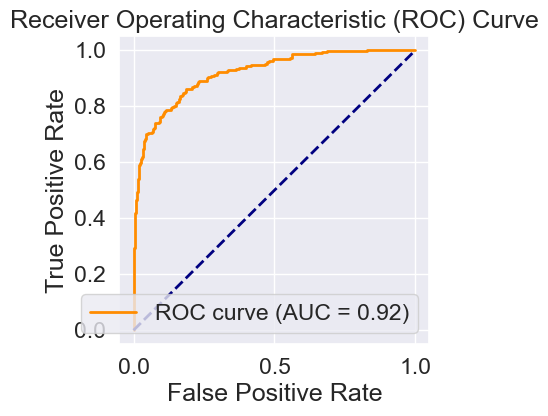

In [437]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calcular el área bajo la curva ROC (AUC-ROC)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

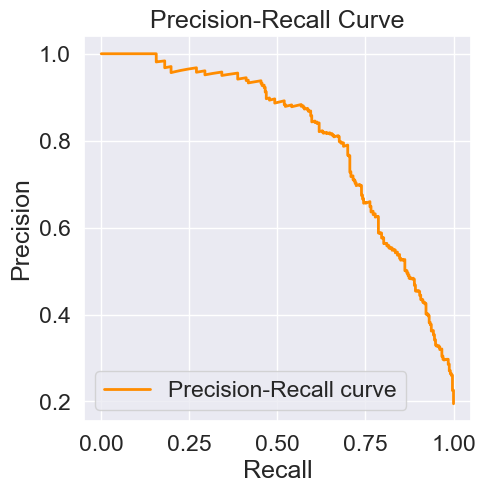

In [439]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(5, 5))
plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


**XGBoost Model without scale_pos_weight (Threshold 0.5):**
**Pros:**
- Higher precision (0.8185): This means that when the model predicts positive, it is correct around 81.85% of the time.
- Decent recall (0.6096): The model is able to capture around 60.96% of actual positive instances.
**Cons:**
- Overall accuracy (0.8977): While accuracy is high, it might be influenced by the class imbalance.

**XGBoost Model with scale_pos_weight=2 and lower threshold (Threshold 0.3):**
**Pros:**
- Improved recall (0.7718): The model is better at capturing positive instances (dementia cases).
- Slightly higher F1 Score (0.6946): A balance between precision and recall.
**Cons:**
- Lower precision (0.6314): The positive predictions are correct around 63.14% of the time.
- Slightly lower accuracy (0.8678): The model might misclassify more instances.

**Considerations:**

If we prioritize identifying as many cases of dementia as possible (higher recall), the second model might be more suitable.
If a balanced trade-off between precision and recall is preferred, the first model is also reasonable.

# 6. Last test: XGboost (34 features)

For the last trial, we wanted to check if our last model (XGboost) could improve if we add some variables related to the clinician and subject judgment of symptoms. We only add 4 more variables from the new CSV.

In [460]:
uds = pd.read_csv("OASIS3_UDSb9_symptoms.csv")

In [461]:
columnas_a_unir= ["OASISID", 'DECSUB', 'DECIN', 'DECCLIN', 'DECCLCOG']

In [462]:
#we remove the subjects that are duplicated
uds_sin_duplicados = uds.drop_duplicates(subset='OASISID')

In [463]:
#we add the new columns to our dataframe
df_merged6 = pd.merge(df_merged2, uds_sin_duplicados [columnas_a_unir], on='OASISID', how='left')

In [465]:
df_merged6.head()

,OASISID,age at visit,PD,HYPERTEN,HYPERCHO,DIABETES,B12DEF,THYROID,ALCOHOL,TOBAC100,SMOKYRS,PACKSPER,QUITSMOK,COMBINED_CV,COMBINED_CB,COMBINED_TRAUMA,COMBINED_INCONT,DEPRESSION,DRUGS,MMSE,Outcome,mood_disorder,GENDER,EDUC,SES,racecode,daddem,momdem,APOE,Hand_L,Hand_R,DECSUB,DECIN,DECCLIN,DECCLCOG
0,OAS30001,65.19,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,0,0,2,12.0,4.0,5,5.0,1.0,23.0,0,1,0.0,0.0,0.0,NaN
1,OAS30001,66.12,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,0,0,2,12.0,4.0,5,5.0,1.0,23.0,0,1,0.0,0.0,0.0,NaN
2,OAS30001,67.17,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,30.0,0,0,2,12.0,4.0,5,5.0,1.0,23.0,0,1,0.0,0.0,0.0,NaN
3,OAS30001,68.22,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0,0,2,12.0,4.0,5,5.0,1.0,23.0,0,1,0.0,0.0,0.0,NaN
4,OAS30001,69.18,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0,0,2,12.0,4.0,5,5.0,1.0,23.0,0,1,0.0,0.0,0.0,NaN


In [466]:
df_merged6.fillna(0, inplace=True)

In [467]:
df_merged6.drop(["OASISID"], axis = 1, inplace=True)

We tried again the last model with a treshold of 0.3.

In [497]:
import xgboost as xgb
X=df_merged6.drop(["Outcome"], axis=1)
y=df_merged6['Outcome'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'scale_pos_weight': 2
}
num_rounds = 100  
model3 = xgb.train(params, dtrain, num_rounds)
y_pred_proba = model3.predict(dtest)
y_pred3 = [1 if proba >= 0.3 else 0 for proba in y_pred_proba] #we lower the threshold from 0.5 to 0.3

accuracy = accuracy_score(y_test, y_pred3)
print("Accuracy on Test Set:", accuracy)

print("\nClassification Report:\n", classification_report(y_test, y_pred3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred3))

Accuracy on Test Set: 0.8970760233918129

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.91      0.93      1377
           1       0.70      0.83      0.76       333

    accuracy                           0.90      1710
   macro avg       0.83      0.87      0.85      1710
weighted avg       0.91      0.90      0.90      1710


Confusion Matrix:
 [[1258  119]
 [  57  276]]


/Users/lauradiazmunozmanzanares/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [13:50:40] WARNING: /private/var/folders/7y/zsyp5rf118nddtsysc4h19h00000gn/T/pip-install-m76ggad_/xgboost_25749e648657441ab762f606448aa50e/cpp_src/src/learner.cc:742: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [498]:
# Calcular métricas
accuracy = accuracy_score(y_test, y_pred3)
precision = precision_score(y_test, y_pred3)
recall = recall_score(y_test, y_pred3)
f1 = f1_score(y_test, y_pred3)
conf_matrix = confusion_matrix(y_test, y_pred3)

# Imprimir resultados
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)

Accuracy: 0.8971
Precision: 0.6987
Recall: 0.8288
F1 Score: 0.7582

Confusion Matrix:
 [[1258  119]
 [  57  276]]


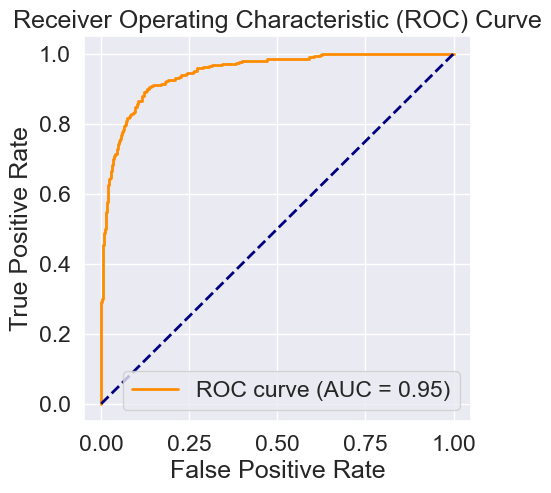

AUC-ROC: 0.9481682117847694


In [469]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

# Obtener las probabilidades de predicción para la clase positiva
y_pred_proba = model.predict(dtest)

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calcular el área bajo la curva ROC (AUC-ROC)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

roc_auc = roc_auc_score(y_test, y_pred_proba)

# Imprimir el valor numérico del AUC
print("AUC-ROC:", roc_auc)

**Considerations from the last model:**
**XGBoost Model with scale_pos_weight=2, lower threshold (0.3), and additional features:**

**Pros:**
- **Higher recall (0.8288):** The model is effective at capturing a higher percentage of actual positive instances.
- **Improved F1 Score (0.7582):** A balance between precision and recall, considering both false positives and false negatives.
**Cons:**
- **Lower precision (0.6987):** The positive predictions are correct around 69.87% of the time.

**Considerations:**

This model appears to have a good balance between precision and recall, as indicated by the F1 Score.
The improved recall suggests that the model is better at identifying positive instances compared to the previous XGBoost models and Random Forest.

**Conclusion:**

The third XGBoost model seems to outperform the first two XGboost models and the Random Forest models in terms of capturing positive instances (higher recall) while maintaining a reasonable precision and F1 Score.
As capturing dementia cases is a priority and the trade-off between precision and recall is acceptable, the third model could be considered an improvement.

# 7. Comparison of the metrics of the models

In [499]:
# define an auxiliary function that plots the results according to the specified model.
def funcionpro(model):

    if model==rus:
        nombre='Random Forest Undersampler'
        y_pred_test=rus_prediction 
    elif model==ros:
        nombre='Random Forest Oversampler'
        y_pred_test=ros_prediction
    elif model==model1:
        nombre='XGboost - 0.5'
        y_pred_test=y_pred1
    elif model==model2:
        nombre='XGboost - 0.3'
        y_pred_test=y_pred2
    elif model==model3:
        nombre='XGboost - 0.3-34 features'
        y_pred_test=y_pred3 


    print(nombre)
    # Show the result of the metrics
    print('')
    print('Accuracy score:', round(accuracy_score(y_test,y_pred_test), 4))
    print('Confusion matrix:')


    # Simple confusion matrix.
    #print(confusion_matrix(y_test, y_pred_test))


    # More aesthetic confusion matrix
    cm = sns.light_palette("lightblue", as_cmap=True)
    x1=pd.DataFrame(confusion_matrix(y_test, y_pred_test))
    vmin1=confusion_matrix(y_test, y_pred_test).min()
    vmax1=confusion_matrix(y_test, y_pred_test).max()
    x1=x1.style.background_gradient(cmap=cm, vmin=vmin1, vmax=vmax1)
    display(x1)
    report = classification_report(y_test, y_pred_test, target_names=['Dementia', 'Non dementia'], output_dict=True)
    print('')
    df_report = pd.DataFrame(report).transpose().round(4)
    df_report.drop(['accuracy', 'macro avg', 'weighted avg'], inplace=True)

    # Format the table using tabulate
    table = tabulate(df_report, headers='keys', tablefmt='grid')


    # Imprimir la tabla
    print('')
    print(table)
    print('')
    print('')
    print('-------------------------------------------------------------------')
    print('')
    print('')

In [500]:
funcionpro(rus)
funcionpro(ros)
funcionpro(model1)
funcionpro(model2)
funcionpro(model3)

Random Forest Undersampler

Accuracy score: 0.8339
Confusion matrix:


,0,1
0,1147,230
1,54,279




+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
+==============+=============+==========+============+===========+
| Dementia     |      0.955  |   0.833  |     0.8898 |      1377 |
+--------------+-------------+----------+------------+-----------+
| Non dementia |      0.5481 |   0.8378 |     0.6627 |       333 |
+--------------+-------------+----------+------------+-----------+


-------------------------------------------------------------------


Random Forest Oversampler

Accuracy score: 0.9018
Confusion matrix:


,0,1
0,1316,61
1,107,226




+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
+==============+=============+==========+============+===========+
| Dementia     |      0.9248 |   0.9557 |      0.94  |      1377 |
+--------------+-------------+----------+------------+-----------+
| Non dementia |      0.7875 |   0.6787 |      0.729 |       333 |
+--------------+-------------+----------+------------+-----------+


-------------------------------------------------------------------


XGboost - 0.5

Accuracy score: 0.8977
Confusion matrix:


,0,1
0,1332,45
1,130,203




+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
+==============+=============+==========+============+===========+
| Dementia     |      0.9111 |   0.9673 |     0.9384 |      1377 |
+--------------+-------------+----------+------------+-----------+
| Non dementia |      0.8185 |   0.6096 |     0.6988 |       333 |
+--------------+-------------+----------+------------+-----------+


-------------------------------------------------------------------


XGboost - 0.3

Accuracy score: 0.8678
Confusion matrix:


,0,1
0,1227,150
1,76,257




+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
+==============+=============+==========+============+===========+
| Dementia     |      0.9417 |   0.8911 |     0.9157 |      1377 |
+--------------+-------------+----------+------------+-----------+
| Non dementia |      0.6314 |   0.7718 |     0.6946 |       333 |
+--------------+-------------+----------+------------+-----------+


-------------------------------------------------------------------


XGboost - 0.3-34 features

Accuracy score: 0.8971
Confusion matrix:


,0,1
0,1258,119
1,57,276




+--------------+-------------+----------+------------+-----------+
|              |   precision |   recall |   f1-score |   support |
+==============+=============+==========+============+===========+
| Dementia     |      0.9567 |   0.9136 |     0.9346 |      1377 |
+--------------+-------------+----------+------------+-----------+
| Non dementia |      0.6987 |   0.8288 |     0.7582 |       333 |
+--------------+-------------+----------+------------+-----------+


-------------------------------------------------------------------


